In [1]:
'''
reference: 
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
'''

import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from blackjackddenv import BlackjackEnv
from explore_strategy import Agent


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions, noise = False):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, n_actions)
        self.noise = noise

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        scale = 0.1
        x = F.relu(self.layer1(x))
        if self.noise:
            x = x + torch.normal(0, scale, size = x.shape, device = device)
        x = F.relu(self.layer2(x))
        if self.noise:
            x = x + torch.normal(0, scale, size = x.shape, device = device)
        x = self.layer3(x)
        return F.softmax(x, dim=1)
    


In [2]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def select_action(state, mode, steps_done):
    
    action_values = torch.zeros(size = [1, n_actions])
    with torch.no_grad():
        action_values = policy_net(state)
    
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    action = -1
    
    if mode == 'greedy':
        if sample > eps_threshold:
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                action = action_values.max(1)[1].item()
        else:
            action = env.action_space.sample()

    if mode == 'thompson':
        action = agent.get_thompson_sampling_action()
        
    if mode == 'boltzmann':
        action = agent.get_boltzmann_action(action_values)
        
        
    if action == 2 and not state[0][3]:
        action = 1
        
    return torch.tensor([[action]], device=device, dtype=torch.long)


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Payouts')
    plt.plot(durations_t.numpy())

In [3]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [4]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 256
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
env = BlackjackEnv()
agent = Agent(env)
n_actions = env.action_space.n
state= env._reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(20000)
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

episode_durations = []
steps_done = 0


def reset(noise = False):
    '''
    lots of variables here are global variables
    '''
    global env, agent, policy_net, target_net, optimizer, memory, Transition, steps_done
    
    
    env = BlackjackEnv()
    agent = Agent(env)
    # Get number of actions from gym action space
    n_actions = env.action_space.n
    # Get the number of state observations
    state= env._reset()
    n_observations = len(state)

    policy_net = DQN(n_observations, n_actions, noise).to(device)
    target_net = DQN(n_observations, n_actions, noise).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
    memory = ReplayMemory(20000)
    Transition = namedtuple('Transition',
                            ('state', 'action', 'next_state', 'reward'))

    episode_durations.clear()
    steps_done = 0
    
    
def train(num_episodes = 50, num_rounds = 100, mode = 'greedy', noise = False):
    reset(noise)
    from tqdm import tqdm
    for i_episode in tqdm(range(num_episodes)):
        # Initialize the environment and get it's state
        state = env._reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        total_payout = 0
        # while not out_of_deck:
        for t in range(num_rounds):
            action = select_action(state, mode, steps_done)
            observation, reward, is_done, out_of_deck, _ = env._step(action.item())

            if mode=='thompson':
                agent.update_thompson_sampling_action(reward, action.item())

            total_payout += reward
            reward = torch.tensor([reward], device=device)

            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if is_done:
                state = env._reset() # Environment deals new cards to player and dealer
                state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        episode_durations.append(total_payout)

    print('Complete')
    print(sum(episode_durations)/len(episode_durations))
    plot_durations(show_result=True)
    plt.ioff()
    plt.show()

HELLO


HELLO


100%|██████████| 50/50 [02:41<00:00,  3.24s/it]

Complete
-390.53


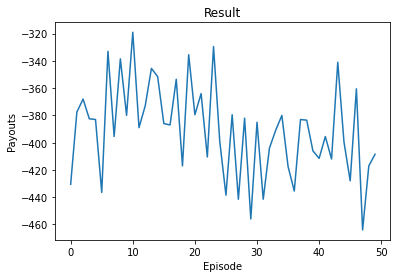

In [5]:
train(50, 1000, 'greedy')

HELLO


100%|██████████| 50/50 [02:50<00:00,  3.41s/it]

Complete
-392.62


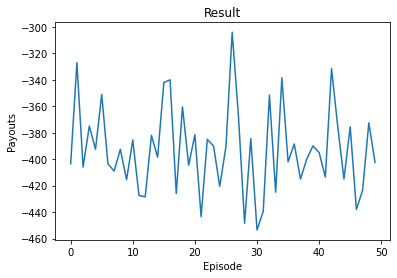

In [6]:
train(50, 1000, 'greedy', noise = True)

HELLO


100%|██████████| 50/50 [02:08<00:00,  2.58s/it]

Complete
-159.7


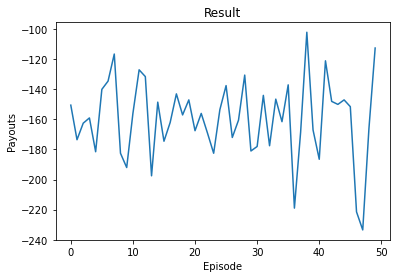

In [7]:
train(50, 1000, 'thompson')

HELLO


100%|██████████| 50/50 [02:51<00:00,  3.43s/it]

Complete
-434.63


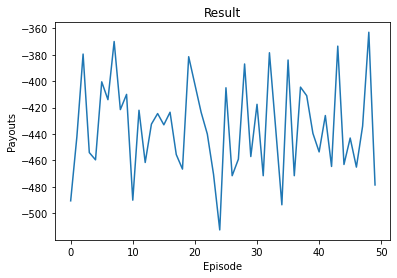

In [8]:
train(50, 1000, 'boltzmann')